# Implementation of (simplified) CryptoNet and AlexNet for inference under homomorphic encryption

In [6]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import save_image
import torch.optim as optim
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math


Approximated Relus

In [7]:
def approx_relu_2d(x):
  """2-degree approx of relu in [-6,6] from https://arxiv.org/pdf/2009.03727.pdf"""
  a = 0.563059
  b = 0.5
  c = 0.078047
  x_2 = torch.square(x)
  return a + b*x + c*x_2
  
def approx_relu_4d(x):
  """4-degree approx of relu in [-6,6] from https://arxiv.org/pdf/2009.03727.pdf"""
  a = 0.119782
  b = 0.5
  c = 0.147298
  d = -0.002015
  x_2 = torch.square(x)
  x_4 = torch.square(x_2)
  return a + b*x + c*x_2 + d*x_4

CryptoNet from [Microsoft](https://www.microsoft.com/en-us/research/publication/cryptonets-applying-neural-networks-to-encrypted-data-with-high-throughput-and-accuracy/)

In [8]:
class ScaledAvgPool2d(nn.Module):
    """Define the ScaledAvgPool layer, a.k.a the Sum Pool"""
    def __init__(self,kernel_size):
      super().__init__()
      self.kernel_size = kernel_size
      self.AvgPool = nn.AvgPool2d(kernel_size=self.kernel_size, stride=1, padding=int(math.ceil((kernel_size-1)/2)))

    def forward(self,x):
      return (self.kernel_size**2)*self.AvgPool(x)
    

class CryptoNet(nn.Module):
  '''
    Original 9-layer network used during training
    CURRENTLY NOT WORKING
  '''
  def __init__(self, verbose):
    super().__init__()
    self.verbose = verbose
    self.pad = F.pad
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5, stride=2)
    self.square1 = torch.square
    self.scaledAvgPool1 = ScaledAvgPool2d(kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=5, out_channels=50, kernel_size=5, stride=2)
    self.scaledAvgPool2 = ScaledAvgPool2d(kernel_size=3)
    self.fc1 = nn.Linear(in_features=1250, out_features=100)
    self.square2 = torch.square
    self.fc2 = nn.Linear(in_features=100, out_features=10)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.pad(x, (1,0,1,0))
    if self.verbose:
      print("Start --> ",x.mean())
    x = self.conv1(x)
    if self.verbose:
      print("Conv1 --> ",x.mean())
    x = self.square1(x)
    if self.verbose:
      print("Sq --> ",x.mean())
    x = self.scaledAvgPool1(x)
    if self.verbose:
      print("Pool --> ",x.mean())
    x = self.conv2(x)
    if self.verbose:
      print("Conv2 --> ",x.mean())
    x = self.scaledAvgPool2(x)
    if self.verbose:
      print("Pool --> ",x.mean())
    ## Flatten
    x = x.reshape(x.shape[0], -1)
    x = self.fc1(x)
    if self.verbose:
      print("fc1 --> ",x.mean())
    x = self.square2(x)
    if self.verbose:
      print("Square --> ",x.mean())
    x = self.fc2(x)
    if self.verbose:
      print("fc2 --> ",x.mean())
    x = self.sigmoid(x)
    return x

  def weights_init(self, m):
    """ Custom initilization to avoid square activation to blow up """
    for m in self.children():
      if isinstance(m,nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
      elif isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, 1e-4,1e-3)


In [9]:
class SimpleNet(nn.Module):
  '''
    Simpliefied network used in paper for inference https://www.microsoft.com/en-us/research/publication/cryptonets-applying-neural-networks-to-encrypted-data-with-high-throughput-and-accuracy/
  '''
  def __init__(self, batch_size : int, activation : str, init_method : str, verbose : bool):
    super().__init__()
    self.verbose = verbose
    self.init_method = init_method
    self.batch_size = batch_size

    if activation == "square":
      self.activation = torch.square
    elif activation == "relu":
      self.activation = nn.ReLU()
    elif activation == "a-relu-2d":
      self.activation = approx_relu_2d
    elif activation == "a-relu-4d":
      self.activation = approx_relu_4d

    self.pad = F.pad
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5, stride=2)
    self.pool1 = nn.Conv2d(in_channels=5, out_channels=100, kernel_size=13, stride=1000)
    self.pool2 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(100,1), stride=1000)

  def forward(self, x):
    x = self.pad(x, (1,0,1,0))
    x = self.conv1(x)
    x = self.activation(self.pool1(x))
    x = x.reshape([self.batch_size,1,100,1]) #batch_size tensors in 1 channel, 100x1
    x = self.activation(self.pool2(x))
    x = x.reshape(x.shape[0], -1)
    return x
 
  def weights_init(self, m):
    for m in self.children():
      if isinstance(m,nn.Conv2d):
        if self.init_method == "he":
          nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
        elif self.init_method == "xavier":
          nn.init.xavier_uniform_(m.weight, gain=math.sqrt(2))
        elif self.init_method == "uniform":
          nn.init.uniform_(m.weight, -0.5, 0.5)
        elif self.init_method == "norm":
          nn.init.normal_(m.weight, 0.0, 1.0)

Modified AlexNet with ReLU approximation

In [10]:
class AlexNet(nn.Module):
  def __init__(self, verbose: bool):
    super().__init__()
    self.verbose = verbose
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0)
    self.pool = nn.AvgPool2d(kernel_size=3, stride=2) ## this used to be MaxPool
    self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding= 2)
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding= 1)
    self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
    self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
    self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
    self.fc3 = nn.Linear(in_features=4096 , out_features=10)

  def forward(self,x):
    """
      TO DO:
        probably we must use square because the degree explodes with the number of layers and becomes too computationally complex
        refer to https://arxiv.org/pdf/1412.6181.pdf     
    """
    x = approx_relu_2d(self.conv1(x))
    x = self.pool(x)
    x = approx_relu_2d(self.conv2(x))
    x = self.pool(x)
    x = approx_relu_2d(self.conv3(x))
    x = approx_relu_2d(self.conv4(x))
    x = approx_relu_2d(self.conv5(x))
    x = self.pool(x)
    x = x.reshape(x.shape[0], -1)
    x = approx_relu_2d(self.fc1(x))
    x = approx_relu_2d(self.fc2(x))
    x = self.fc3(x)
    x = torch.sigmoid(x) ## this used to be softmax
    return x

Load Datasets

In [11]:
class DataHandler():
  def __init__(self, dataset : str, batch_size : int, model : str):
    if dataset == "MNIST":
      self.batch_size = batch_size
      if model == "crypto":
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
      elif model == "alex":
        transform = transforms.Compose([
          transforms.Resize((227, 227)),
          transforms.ToTensor(),
          transforms.Normalize((0.1307,), (0.3081,))
        ])

      train_ds = MNIST("data/", train=True, download=True, transform=transform)
      test_ds = MNIST("data/", train=False, download=True, transform=transforms.ToTensor())

      self.train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True, drop_last=True,num_workers=2, pin_memory=True)
      self.test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle=True, drop_last=True,num_workers=2, pin_memory=True)

Plot gradient flow

In [12]:
def plot_grad_flow(named_parameters):
    ## From https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063
    ## Beware it's a little bit tricky to interpret results
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''

    ave_grads = []
    max_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
            print(f"Layer {n}, grad avg {p.grad.mean()}, data {p.data.mean()}")
    plt.bar(np.arange(len(max_grads)), max(max_grads), alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), np.mean(ave_grads), alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    


Training of 9-layer CryptoNet --> not working

In [ ]:
"""
## setup torch enviro
torch.manual_seed(9325345339582034)
torch.autograd.set_detect_anomaly(True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## init model
model = CryptoNet(verbose=False)
model.apply(model.weights_init)
model = model.to(device=device)

dataHandler = DataHandler("MNIST")

## training params setup
learning_rate = 3e-4
momentum = 0.9
num_epochs = 5000
total_step = len(dataHandler.train_dl)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(num_epochs):
  for i, (data, labels) in enumerate(dataHandler.train_dl):
    data = data.to(device=device)
    labels = labels.to(device=device)
    #labels = labels.to(torch.float32)

    optimizer.zero_grad()
    predictions = model(data)
    loss = criterion(predictions, labels)
    loss.backward()
    if model.verbose:
      print(f"[?] Step {i+1} Epoch {epoch+1}")
      plot_grad_flow(model.named_parameters())
    optimizer.step()

    if (i+1) % 50 == 0:
      print ('[!] Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

torch.save(model, "cryptoNet.pt")
"""

Train and test pipeline

[!] Train Epoch [1/60], Step [200/234] ==> Loss: 0.3362
[!] Train Epoch [2/60], Step [200/234] ==> Loss: 0.2531
[!] Train Epoch [3/60], Step [200/234] ==> Loss: 0.1523
[!] Train Epoch [4/60], Step [200/234] ==> Loss: 0.1403
[!] Train Epoch [5/60], Step [200/234] ==> Loss: 0.0833
[!] Train Epoch [6/60], Step [200/234] ==> Loss: 0.1762
[!] Train Epoch [7/60], Step [200/234] ==> Loss: 0.1115
[!] Train Epoch [8/60], Step [200/234] ==> Loss: 0.0897
[!] Train Epoch [9/60], Step [200/234] ==> Loss: 0.0406
[!] Train Epoch [10/60], Step [200/234] ==> Loss: 0.0697
[!] Train Epoch [11/60], Step [200/234] ==> Loss: 0.0624
[!] Train Epoch [12/60], Step [200/234] ==> Loss: 0.0702
[!] Train Epoch [13/60], Step [200/234] ==> Loss: 0.0320
[!] Train Epoch [14/60], Step [200/234] ==> Loss: 0.0198
[!] Train Epoch [15/60], Step [200/234] ==> Loss: 0.0448
[!] Train Epoch [16/60], Step [200/234] ==> Loss: 0.0396
[!] Train Epoch [17/60], Step [200/234] ==> Loss: 0.0633
[!] Train Epoch [18/60], Step [200/234] 

<ipython-input-14-30bfca31f074>:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots( 1, 2, figsize = (12,4) )


Average test Loss ==> 0.021261151568972694
Test accuracy ==> 80.42
[!] Train Epoch [1/60], Step [200/234] ==> Loss: 0.3502
[!] Train Epoch [2/60], Step [200/234] ==> Loss: 0.2580
[!] Train Epoch [3/60], Step [200/234] ==> Loss: 0.1644
[!] Train Epoch [4/60], Step [200/234] ==> Loss: 0.1978
[!] Train Epoch [5/60], Step [200/234] ==> Loss: 0.1538
[!] Train Epoch [6/60], Step [200/234] ==> Loss: 0.2147
[!] Train Epoch [7/60], Step [200/234] ==> Loss: 0.1394
[!] Train Epoch [8/60], Step [200/234] ==> Loss: 0.0963
[!] Train Epoch [9/60], Step [200/234] ==> Loss: 0.0995
[!] Train Epoch [10/60], Step [200/234] ==> Loss: 0.1543
[!] Train Epoch [11/60], Step [200/234] ==> Loss: 0.0803
[!] Train Epoch [12/60], Step [200/234] ==> Loss: 0.0847
[!] Train Epoch [13/60], Step [200/234] ==> Loss: 0.1200
[!] Train Epoch [14/60], Step [200/234] ==> Loss: 0.1023
[!] Train Epoch [15/60], Step [200/234] ==> Loss: 0.1053
[!] Train Epoch [16/60], Step [200/234] ==> Loss: 0.0802
[!] Train Epoch [17/60], Step 

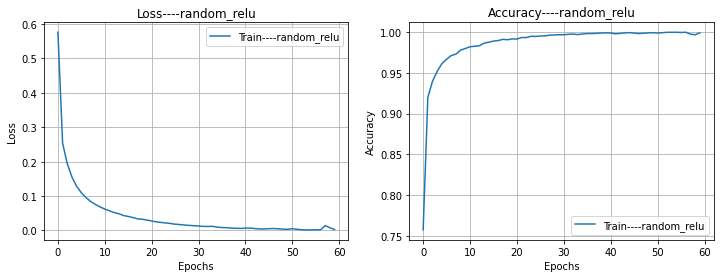

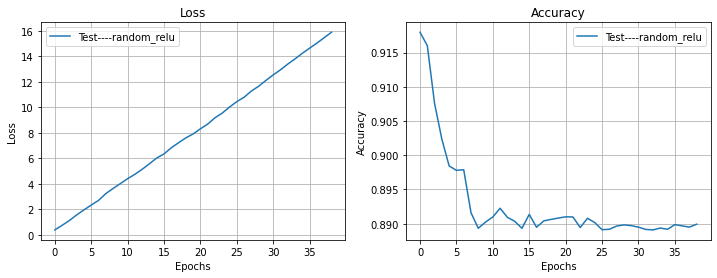

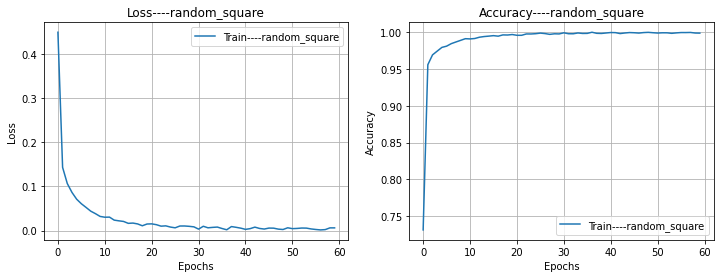

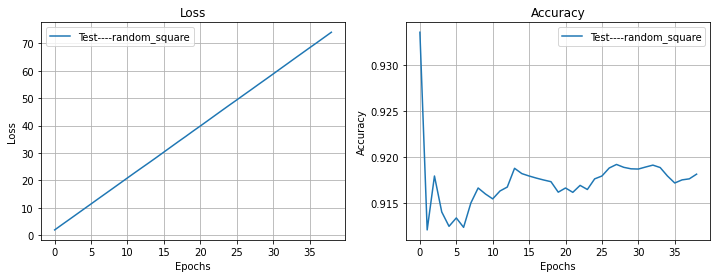

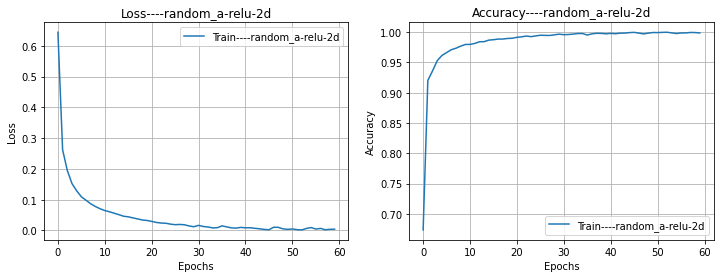

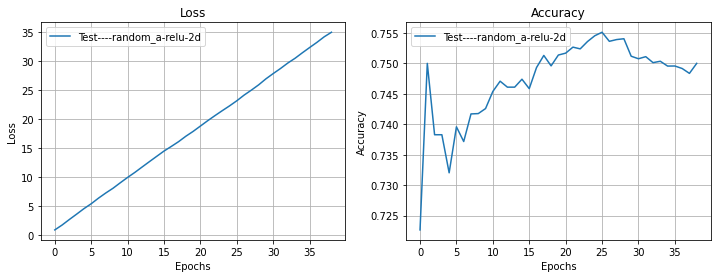

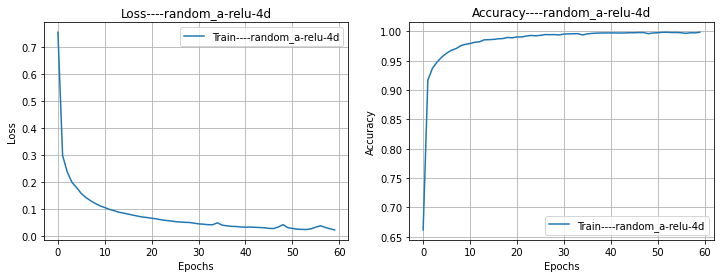

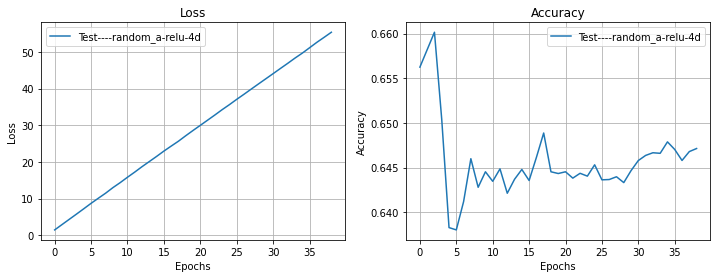

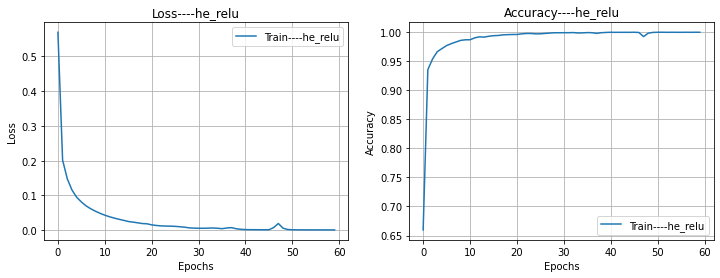

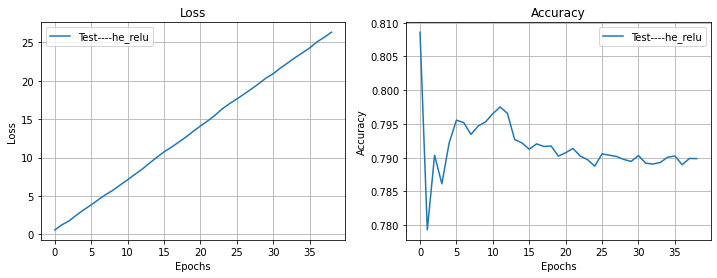

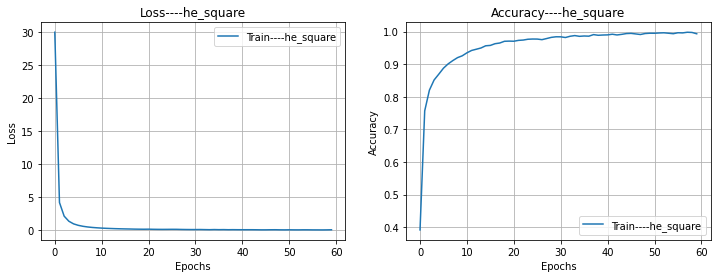

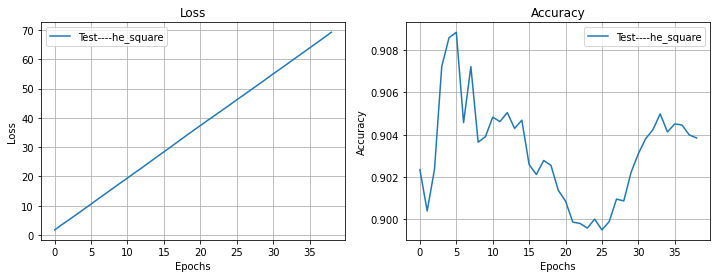

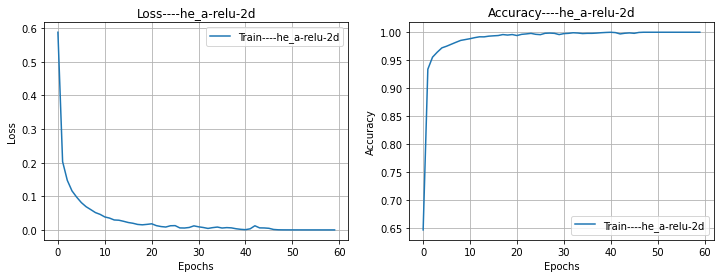

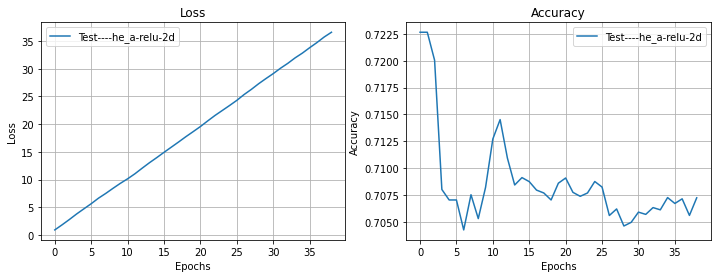

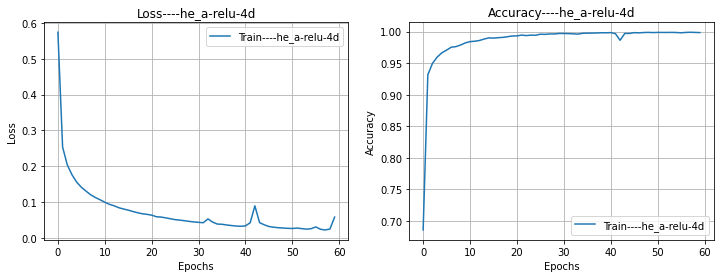

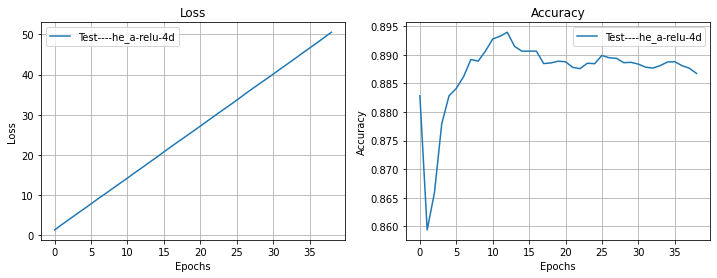

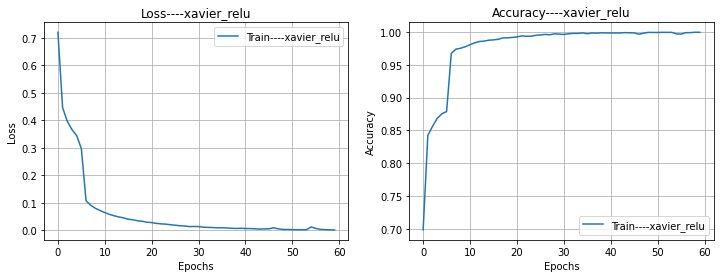

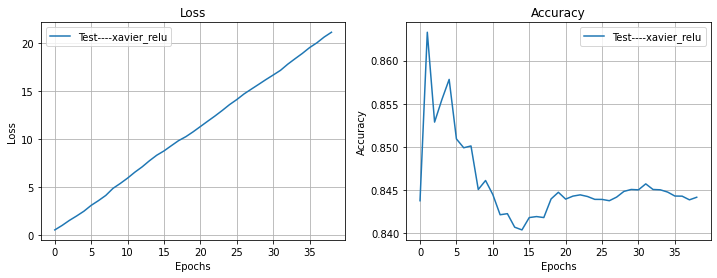

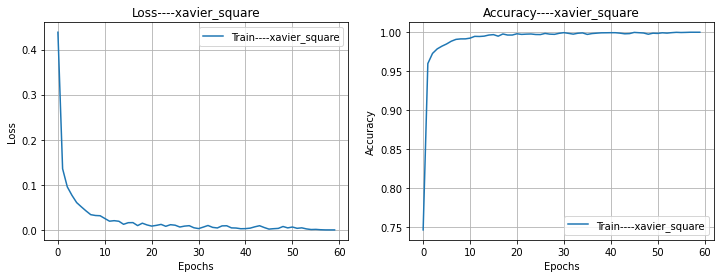

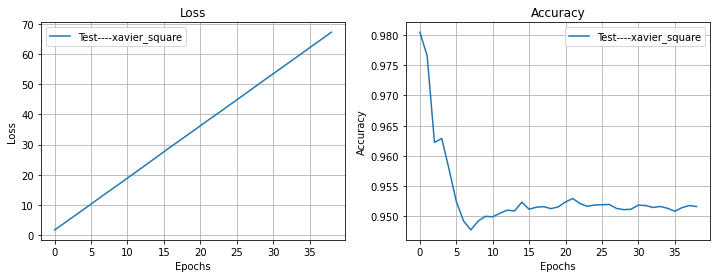

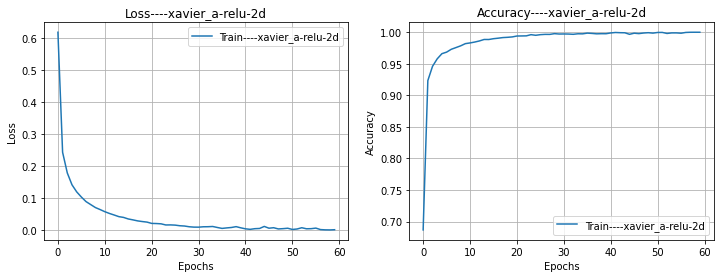

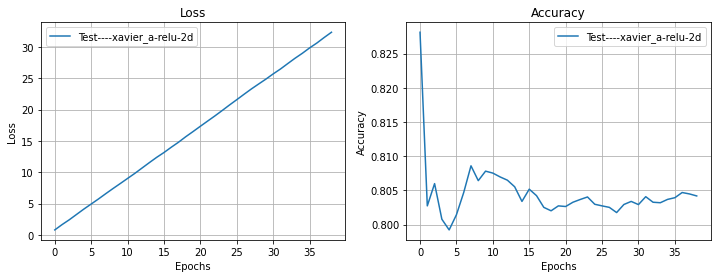

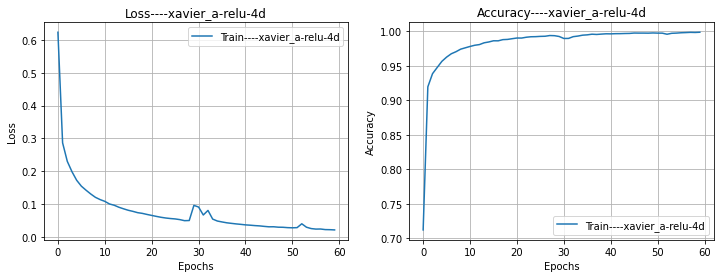

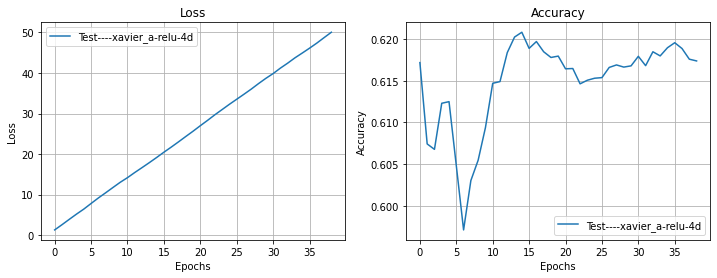

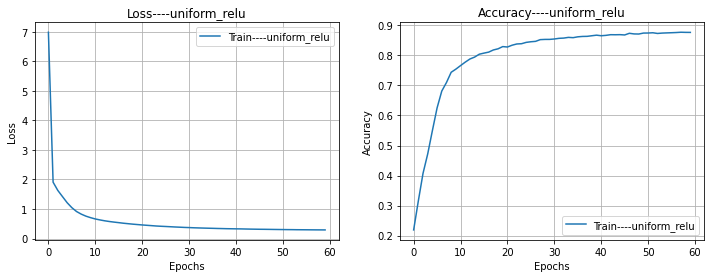

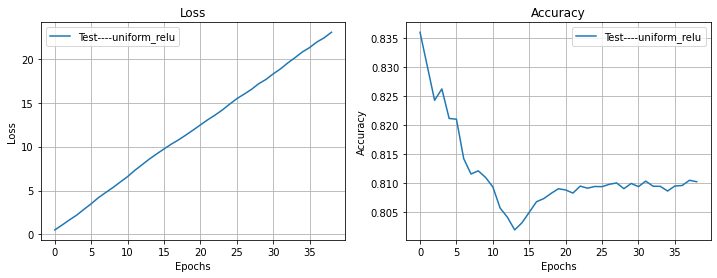

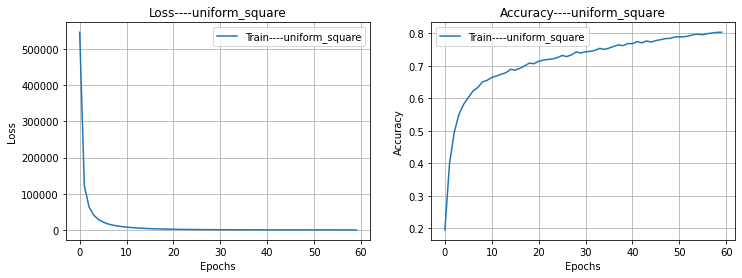

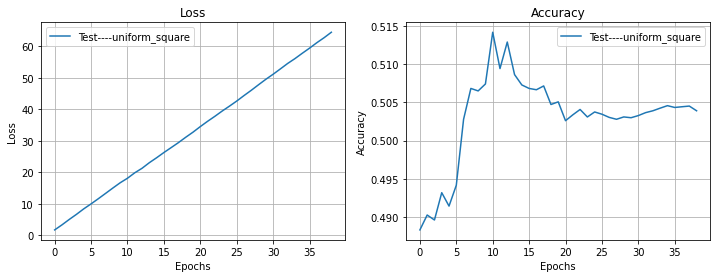

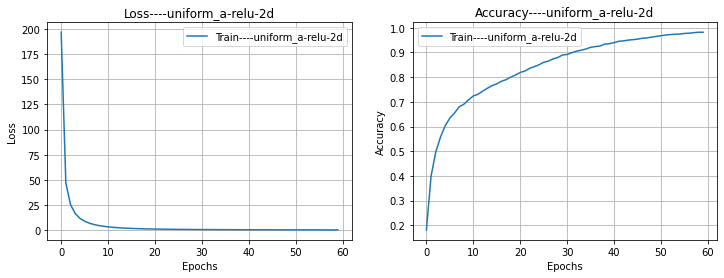

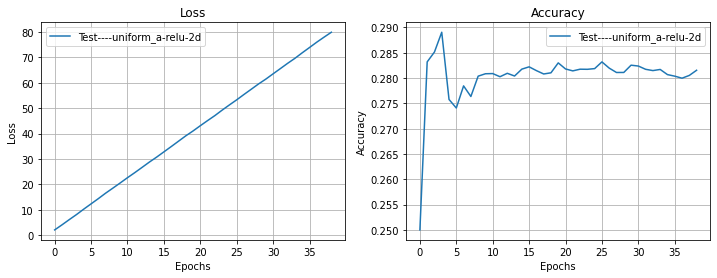

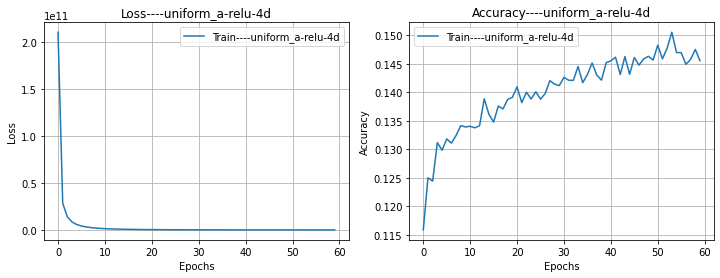

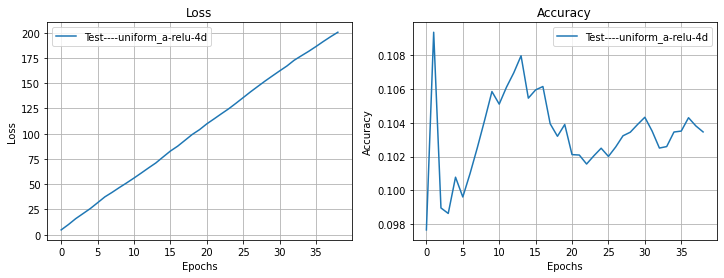

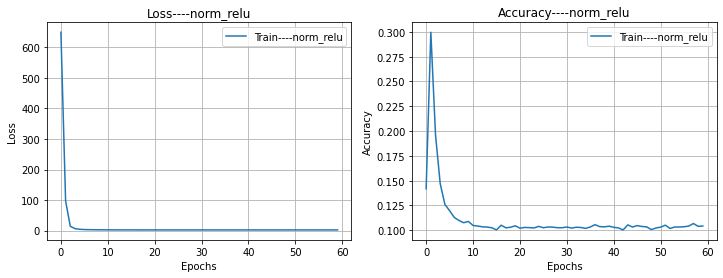

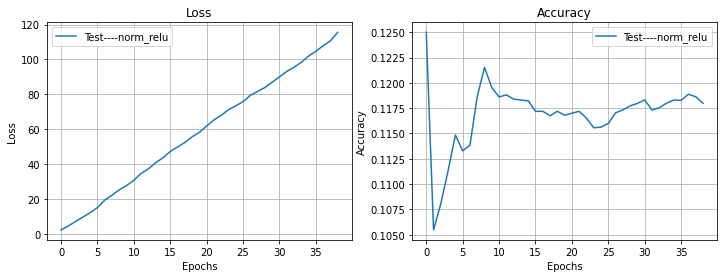

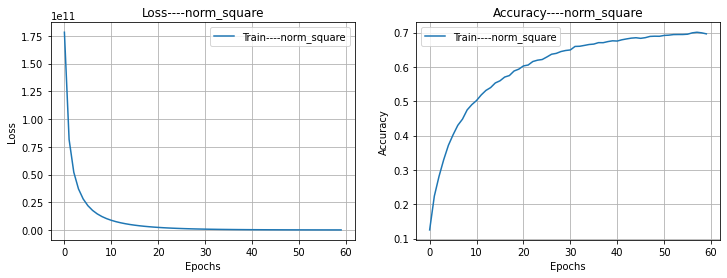

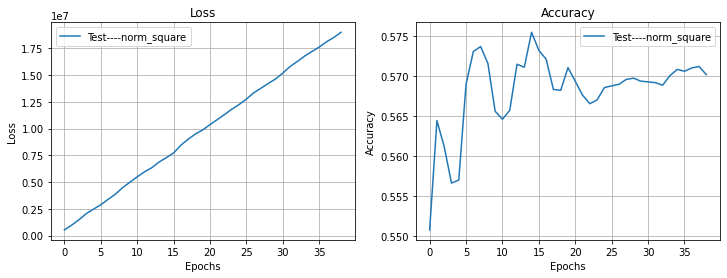

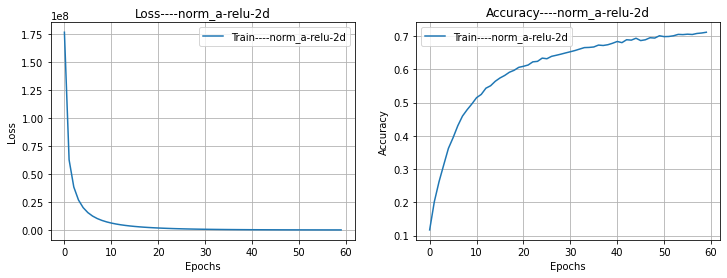

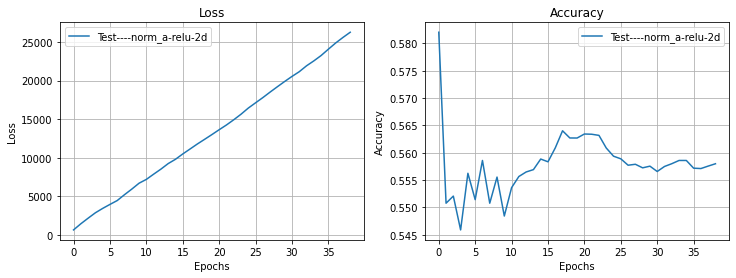

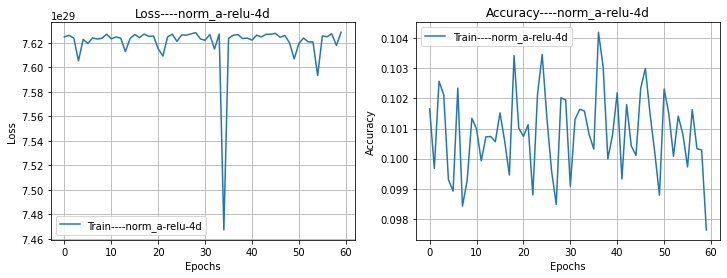

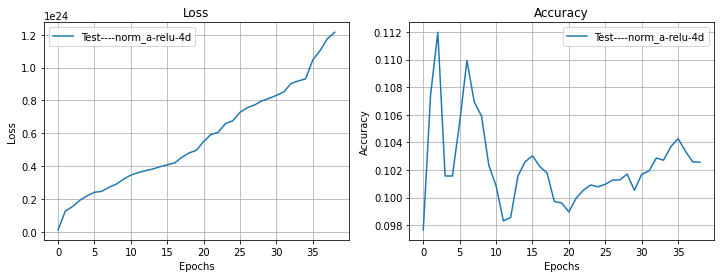

In [14]:
## setup torch enviro
torch.manual_seed(42)
torch.autograd.set_detect_anomaly(True)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataHandler = DataHandler(dataset="MNIST", batch_size=256, model="crypto")

## training params setup
learning_rate = 3e-4
total_step = len(dataHandler.train_dl)
criterion = nn.CrossEntropyLoss()

def train(key, model, dataHandler, num_epochs):
  num_epochs = num_epochs
  model.train()
  #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  trainHistory = {}
  trainHistory['loss'] = []
  trainHistory['accuracy'] = []

  for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    num_correct = 0
    num_samples = 0
    for i, (data, labels) in enumerate(dataHandler.train_dl):
      data = data.to(device=device)
      labels = labels.to(device=device)
      #labels = labels.to(torch.float32)

      optimizer.zero_grad()
      predictions = model(data)
      loss = criterion(predictions, labels)
      loss.backward()
      if model.verbose:
        print(f"[?] Step {i+1} Epoch {epoch+1}")
        plot_grad_flow(model.named_parameters())
      optimizer.step()
      _, predicted_labels = predictions.max(1)
      num_correct += (predicted_labels == labels).sum()
      num_samples += predicted_labels.size(0)
      
      epoch_accuracy += num_correct/num_samples
      epoch_loss += loss.item()

      if (i+1) % 200 == 0:
        print("=====================================================================================================================")
        print ('[!] Train Epoch [{}/{}], Step [{}/{}] ==> Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
      
    trainHistory['loss'].append(epoch_loss/len(dataHandler.train_dl))
    trainHistory['accuracy'].append(epoch_accuracy/len(dataHandler.train_dl))
    
  fig, ax = plt.subplots( 1, 2, figsize = (12,4) )

  ax[0].plot( trainHistory['loss'], label = "Train"+"----"+key)
  ax[0].set_title( "Loss"+"----"+key)
  ax[0].set_xlabel( "Epochs" )
  ax[0].set_ylabel( "Loss" )
  ax[0].grid( True )
  ax[0].legend()

  ax[1].plot( trainHistory['accuracy'], label = "Train"+"----"+key)
  ax[1].set_title( "Accuracy"+"----"+key)
  ax[1].set_xlabel( "Epochs" )
  ax[1].set_ylabel( "Accuracy" )
  ax[1].grid( True )
  ax[1].legend()

def eval(key, model, dataHandler):
  num_correct = 0
  num_samples = 0

  model.eval()
  testHistory = {}
  testHistory['loss'] = []
  testHistory['accuracy'] = []
  loss = 0
  accuracy = 0
  with torch.no_grad():
    for _, (data,labels) in enumerate(dataHandler.test_dl):
        data = data.to(device=device)
        labels = labels.to(device=device)
        ## Forward Pass
        predictions = model(data)
        loss += criterion(predictions, labels).item()
        _, predicted_labels = predictions.max(1)
        num_correct += (predicted_labels == labels).sum()
        num_samples += predicted_labels.size(0)
        testHistory['loss'].append(loss)
        testHistory['accuracy'].append(float(num_correct) / float(num_samples))
  
    accuracy = float(num_correct) / float(num_samples)
    loss = loss/len(dataHandler.test_dl)
    print("==================================================================================================================================================")
    print(f"Average test Loss ==> {loss / len(dataHandler.test_dl)}")
    print(f"Test accuracy ==> {float(num_correct) / float(num_samples) * 100:.2f}")

    fig, ax = plt.subplots( 1, 2, figsize = (12,4) )

  ax[0].plot( testHistory['loss'], label = "Test"+"----"+key)
  ax[0].set_title( "Loss" )
  ax[0].set_xlabel( "Epochs" )
  ax[0].set_ylabel( "Loss" )
  ax[0].grid( True )
  ax[0].legend()

  ax[1].plot( testHistory['accuracy'], label = "Test"+"----"+key)
  ax[1].set_title( "Accuracy" )
  ax[1].set_xlabel( "Epochs" )
  ax[1].set_ylabel( "Accuracy" )
  ax[1].grid( True )
  ax[1].legend()

  return loss, accuracy

##################################################################### TRAINING AND EVAL #######################################################################
## init models
methods = ["random", "he", "xavier", "uniform", "norm"]
activations = ["relu","square", "a-relu-2d", "a-relu-4d"]
models = {}
for method in methods:
  for activation in activations:
    models[method+"_"+activation] = SimpleNet(batch_size=dataHandler.batch_size, activation=activation, init_method=method,verbose=False).to(device=device)
scores = {}
for key, model in models.items():
  model.apply(model.weights_init)
  train(key, model, dataHandler, num_epochs=60)
  loss, accuracy = eval(key,model, dataHandler)
  scores[key] = {"loss":loss, "accuracy":accuracy}
  torch.save(model, f"SimpleNet_{key}.pt")

for key, metrics in scores.items():
  print("===================================================================================================================================================")
  print(f"[+] Model with {key}: Avg test Loss ==> {metrics['loss']}, Accuracy ==> {metrics['accuracy']}")

# Results
- best is xavier with square with 95% accuracy


Training of AlexNet --> too heavy for Google Colab


In [ ]:
dataHandler = dataHandler = DataHandler(dataset="MNIST", batch_size=256, model="alex")
model = AlexNet(False).to(device=device)
train(model, dataHandler, 10)
eval(model, dataHandler)
torch.save(model, "AlexNet.pt")